# Age Estimation based on Human Voice

links:
<br>
https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
<br>
https://github.com/librosa/librosa/issues/720

<br>
Play an audio file.

In [1]:
from pygame import mixer

def play_sound(path):
    mixer.init()
    mixer.music.load(path)
    mixer.music.play()
    
#play_sound("cv_corpus_v1\cv-valid-train\sample-000000.mp3")

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


<br>
Get the max length of audio files.

In [2]:
from os import listdir
from os.path import join

def get_max_length():
    max_length = 0 
    dirs = ["cv-invalid", "cv-other-dev", "cv-other-test", "cv-other-train", "cv-valid-dev", "cv-valid-test", "cv-valid-train"]
    for dir in dirs:
        print(dir)
        for file in listdir(join("cv_corpus_v1", "wav-files", dir)):
            _, audio = wavfile.read(join("cv_corpus_v1", "wav-files", dir, file))
            max_length = max(len(audio), max_length)
    return max_length
                        
#max_length = get_max_length()
max_length = 695060352

<br>
Get info from the dataset.

In [3]:
import pandas as pd

def get_dataframe(path):
    df = pd.read_csv(path)
    return df[pd.notna(df['age'])]

df = get_dataframe(join("cv_corpus_v1", "cv-valid-train.csv"))
df.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN
20,cv-valid-train/sample-000020.mp3,it was faintly marked with transverse stripes ...,5,1,thirties,male,england,NaN
23,cv-valid-train/sample-000023.mp3,i had seen all that it would presently bring me,5,0,thirties,male,us,NaN
26,cv-valid-train/sample-000026.mp3,two years ago right here on this spot i had a ...,4,0,twenties,female,australia,NaN
27,cv-valid-train/sample-000027.mp3,don't let them see that you're afraid the alch...,3,0,twenties,male,australia,NaN
29,cv-valid-train/sample-000029.mp3,the fire alarm went off again but when i looke...,1,0,thirties,male,indian,NaN


In [4]:
import numpy as np

def get_mp3_name(path):
    return "{}.mp3".format(path[:-4]).split("wav-files\\")[1].replace("\\", "/")

def get_age(df, path):
    path = get_mp3_name(path)
    return df.loc[df['filename'] == path]["age"].values[0]

gender_dict = {"male": -1, "female": +1, "other": 0}
def get_gender(df, path):
    path = get_mp3_name(path)
    try:
        gender = df.loc[df['filename'] == path]["gender"].values[0]
        return gender_dict[gender]
    except:
        return gender_dict["other"]
    

print(get_age(df, join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav")))
print(get_gender(df, join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav")))

thirties
-1


<br> 
Get the spectrogram of an audio file.

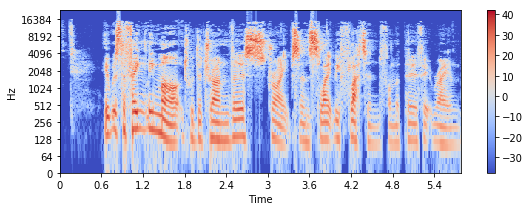

In [50]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def get_spectrogram(path, sampling_rate = 48000, display = True):
    # Load an audio file as a floating point time series.
    audio , _ = librosa.load(path, sr=sampling_rate)

    # Short-time Fourier transform (STFT).
    stft = abs(librosa.stft(audio))

    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    spectrogram = librosa.amplitude_to_db(stft)

    if display:
        plt.figure(figsize=(9, 3))
        librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='log')
        plt.colorbar()
    return spectrogram


_ = get_spectrogram(join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav"))

<br>
Feature Extraction:

* gender
* spectral_centroid computes the "average" frequency at each frame, where frequencies are weighted relatively by their energy.
* spectral_bandwidth similar to centroid, but for variance (or other moments).
* spectral_rolloff essentially the maximum: finds the frequency f such that almost all of the energy (by default, 85%) in the frame is at frequencies below f. If you set the roll-off to a small fraction (say, 10%), this would give you an estimate of the effective minimum frequency.
* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.


In [6]:
import sklearn

def feature_extraction(path, sampling_rate = 48000):
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = get_gender(df, path)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return np.asarray(features, dtype=float)
    
        
features = feature_extraction(join("cv_corpus_v1", "wav-files", "cv-valid-train", "sample-000020.wav"))
print("features: ", features)
print("shape: ", features.shape)

features:  [-1.00000000e+00  3.96891232e+03  2.91252107e+03  6.71275035e+03
 -2.92270602e+02  9.61654429e+01 -5.19889843e+01  4.70060891e+01
 -1.41496992e+01  1.91754064e+01 -1.54290157e+01 -2.08433772e+00
 -2.29711672e+00 -9.35190538e+00 -6.93357493e+00 -6.12214394e+00
  6.41517699e+00 -8.65743293e+00 -3.54438021e+00 -2.85235548e+00
 -2.35155632e+00 -7.71120655e-01  6.51453104e-01 -9.10067695e+00]
shape:  (24,)


<br>
Extract features and save them in new csv files.

In [7]:
import csv

def get_wav_name(path):
    info = path.split("/")
    filename = join("cv_corpus_v1", "wav-files", info[0], "{}.wav".format(info[1][:-4]))
    return filename

def parse(row):
    features = feature_extraction(get_wav_name(row["filename"]))
    label = row["age"]
    return [features, label]

def create_header():
    header = 'filename gender spectral_centroid spectral_bandwidth spectral_rolloff'
    for i in range(1, 21):
        header += ' mfcc{}'.format(i)
    header += ' label'
    header = header.split()
    return header

def create_feature_csv(csv_name, header):
    df = get_dataframe(join("cv_corpus_v1", csv_name))
    with open(join("cv_corpus_v1", "feature-csv", csv_name), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for index, row in df.iterrows():
        to_append = list()
        filename = row["filename"]
        features = feature_extraction(get_wav_name(row["filename"]))
        label = row["age"]
        to_append.append(filename)
        to_append.extend(features)
        to_append.append(label)
        with open(join("cv_corpus_v1", "feature-csv", csv_name), 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(to_append)

header = create_header()
dirs = ["cv-valid-dev.csv", "cv-valid-test.csv", "cv-valid-train.csv", "cv-other-dev.csv", "cv-other-test.csv", "cv-other-train.csv"]
#for el in dirs:
#    create_feature_csv(el, header)

<br>
Join usabel data.

In [8]:
data = pd.concat([pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-train.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-test.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-valid-dev.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-train.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-test.csv")), \
                  pd.read_csv(join("cv_corpus_v1", "feature-csv", "cv-other-dev.csv"))])
print(data.shape)
data.head()

(143170, 26)


,filename,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,cv-valid-train/sample-000005.mp3,1.0,2679.939569,3347.669489,5745.486746,-625.218161,111.320938,6.326994,34.757614,31.619902,...,-10.702963,-11.202637,-12.003523,-8.489580,-5.463277,-4.954217,-3.715199,-6.330530,-6.338474,twenties
1,cv-valid-train/sample-000008.mp3,-1.0,2859.467798,2576.661658,4912.241181,-469.897699,126.299871,-16.546747,3.553604,2.178289,...,-10.987109,1.146530,6.103550,-1.724739,-1.226475,-6.429198,-7.261916,-4.788060,-3.121077,seventies
2,cv-valid-train/sample-000013.mp3,1.0,1976.049163,1830.611037,3344.301008,-418.205057,147.668304,-49.972742,-2.285532,37.187014,...,-13.845864,-9.927491,-7.871619,-5.473860,-2.295656,-6.554991,-5.206915,-0.407431,-3.882371,thirties
3,cv-valid-train/sample-000014.mp3,-1.0,2333.782018,2533.276030,4398.731436,-464.911235,118.436142,19.749295,27.143940,26.439020,...,-5.458494,-2.907650,-4.495940,-2.715732,-0.079106,-5.292980,-5.866176,0.601412,-3.376775,sixties
4,cv-valid-train/sample-000019.mp3,-1.0,2351.958974,2974.758776,4743.172457,-343.828776,157.151765,7.660180,41.900481,-15.153760,...,0.101645,6.319596,-1.603062,3.837601,-2.643969,2.324787,-1.382978,3.790324,-3.534814,fifties


<br>
Encoding the labels.

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(data)
labels = encoder.classes_
print("labels: ", labels)

labels:  ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


<br>
Scaling the features.

In [10]:
def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 1:-1], dtype = float))
    # with data.iloc[:, 1:-1] we don't consider filename and label

    # in this way, gender will be always -1, 0 or +1 and so it won't be scaled
    for i in range(len(scaled_data)):
        scaled_data[i][0] = data.iloc[i, 1]
        
    return scaled_data, scaler

x, scaler = scale_features(data)

<br>
Split data in Training, Test and Validation set.

* Training set:    80 %
* Test set:        10 %
* Validation set:  10 %

In [11]:
# balanced split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("x_val: ", x_val.shape)

x_train:  (114536, 24)
x_test:  (14317, 24)
x_val:  (14317, 24)


<br>

## Classification

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(x_train.shape[1],)))
model.add(layers.Dense(512, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation='softmax'))    # note that 8 is the number of possible labels

Using TensorFlow backend.


In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
__________

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

### First stage of training

In [15]:
epochs = 50
batch_size = 4
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/100
114536/114536 [==============================] - 425s 4ms/step - loss: 1.6588 - acc: 0.3364 - val_loss: 1.5636 - val_acc: 0.3866

Epoch 00001: val_loss improved from inf to 1.56356, saving model to best_model.hdf5
Epoch 2/100
114536/114536 [==============================] - 412s 4ms/step - loss: 1.6044 - acc: 0.3628 - val_loss: 1.5228 - val_acc: 0.4109

Epoch 00002: val_loss improved from 1.56356 to 1.52277, saving model to best_model.hdf5
Epoch 3/100
114536/114536 [==============================] - 414s 4ms/step - loss: 1.5852 - acc: 0.3757 - val_loss: 1.4992 - val_acc: 0.4115

Epoch 00003: val_loss improved from 1.52277 to 1.49918, saving model to best_model.hdf5
Epoch 4/100
114536/114536 [==============================] - 406s 4ms/step - loss: 1.5726 - acc: 0.3807 - val_loss: 1.4640 - val_acc: 0.4224

Epoch 00004: val_loss improved from 1.49918 to 1.46398, saving model to best_model.hdf5
Epoch 5/100
114536/114536 [======

In [16]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 42.54 %


Text(0.5,1,'Accuracy Curves\n(Batch_Size: 8)')

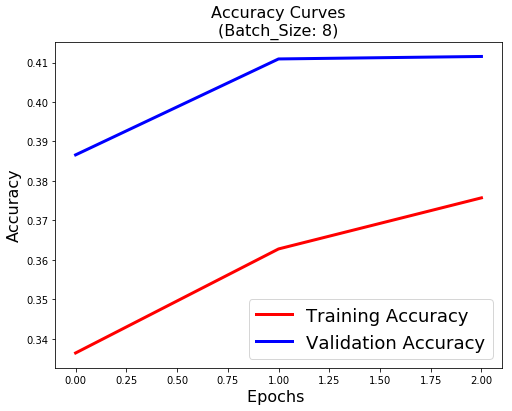

In [24]:
last_good_epoch = early_stopping.stopped_epoch - early_stopping.patience

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'][:last_good_epoch],'r',linewidth=3.0)
plt.plot(history.history['val_acc'][:last_good_epoch],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5,1,'Loss Curves\n(Batch_Size: 8)')

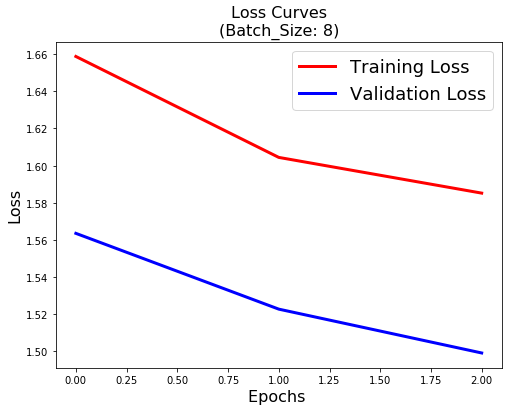

In [25]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'][:last_good_epoch],'r',linewidth=3.0)
plt.plot(history.history['val_loss'][:last_good_epoch],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Second stage of training

In [19]:
epochs = 50
batch_size = 8
history2 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/100
114536/114536 [==============================] - 199s 2ms/step - loss: 1.4102 - acc: 0.4579 - val_loss: 1.2340 - val_acc: 0.5385

Epoch 00001: val_loss improved from 1.46398 to 1.23398, saving model to best_model.hdf5
Epoch 2/100
114536/114536 [==============================] - 196s 2ms/step - loss: 1.3271 - acc: 0.4970 - val_loss: 1.1590 - val_acc: 0.5834

Epoch 00002: val_loss improved from 1.23398 to 1.15898, saving model to best_model.hdf5
Epoch 3/100
114536/114536 [==============================] - 200s 2ms/step - loss: 1.2794 - acc: 0.5178 - val_loss: 1.1424 - val_acc: 0.5988

Epoch 00003: val_loss improved from 1.15898 to 1.14235, saving model to best_model.hdf5
Epoch 4/100
114536/114536 [==============================] - 199s 2ms/step - loss: 1.2477 - acc: 0.5298 - val_loss: 1.0613 - val_acc: 0.6219

Epoch 00004: val_loss improved from 1.14235 to 1.06131, saving model to best_model.hdf5
Epoch 5/100
114536/114536 [==

In [20]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 75.19 %


Text(0.5,1,'Loss Curves\n(Batch_Size: 8)')

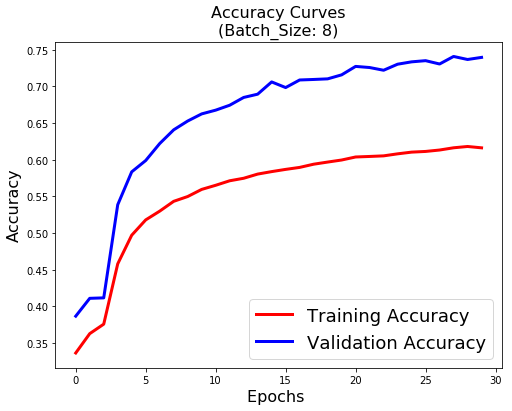

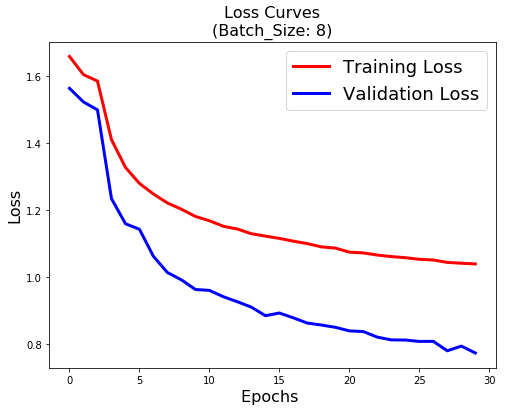

In [26]:
last_good_epoch2 = early_stopping.stopped_epoch - early_stopping.patience

acc_to_plot = history.history['acc'][:last_good_epoch] + history2.history['acc'][:last_good_epoch2]
val_acc_to_plot = history.history['val_acc'][:last_good_epoch] + history2.history['val_acc'][:last_good_epoch2]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


loss_to_plot = history.history['loss'][:last_good_epoch] + history2.history['loss'][:last_good_epoch2]
val_loss_to_plot = history.history['val_loss'][:last_good_epoch] + history2.history['val_loss'][:last_good_epoch2]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Third stage of training

In [27]:
epochs = 50
batch_size = 16
history3 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

Train on 114536 samples, validate on 14317 samples
Epoch 1/100
114536/114536 [==============================] - 102s 893us/step - loss: 0.7657 - acc: 0.7233 - val_loss: 0.6234 - val_acc: 0.7854

Epoch 00001: val_loss improved from 0.75740 to 0.62341, saving model to best_model.hdf5
Epoch 2/100
114536/114536 [==============================] - 102s 888us/step - loss: 0.7450 - acc: 0.7307 - val_loss: 0.6041 - val_acc: 0.7974

Epoch 00002: val_loss improved from 0.62341 to 0.60409, saving model to best_model.hdf5
Epoch 3/100
114536/114536 [==============================] - 103s 898us/step - loss: 0.7332 - acc: 0.7352 - val_loss: 0.5851 - val_acc: 0.8009

Epoch 00003: val_loss improved from 0.60409 to 0.58509, saving model to best_model.hdf5
Epoch 4/100
114536/114536 [==============================] - 99s 863us/step - loss: 0.7195 - acc: 0.7386 - val_loss: 0.5761 - val_acc: 0.8036

Epoch 00004: val_loss improved from 0.58509 to 0.57607, saving model to best_model.hdf5
Epoch 5/100
114536/114

In [28]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

Test accuracy: 84.64 %


Text(0.5,1,'Loss Curves')

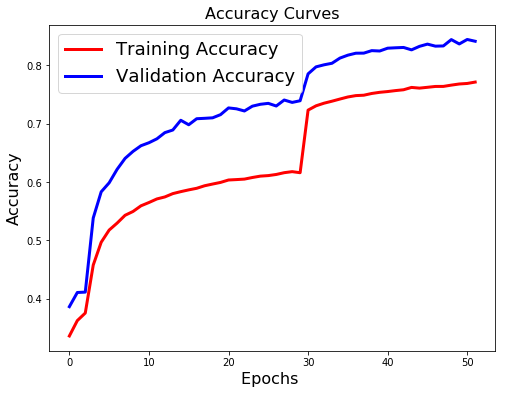

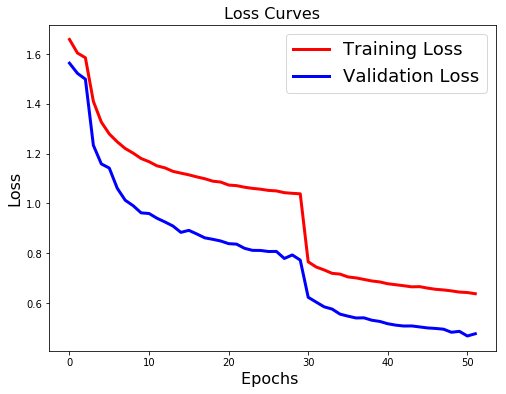

In [49]:
last_good_epoch3 = early_stopping.stopped_epoch - early_stopping.patience

acc_to_plot += history3.history['acc'][:last_good_epoch3]
val_acc_to_plot += history3.history['val_acc'][:last_good_epoch3]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

loss_to_plot += history3.history['loss'][:last_good_epoch3]
val_loss_to_plot += history3.history['val_loss'][:last_good_epoch3]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Fourth stage of training

In [ ]:
epochs = 50
batch_size = 32
history4 = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=(x_val, y_val))

In [ ]:
model.load_weights('best_model.hdf5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: {0:.2f} %".format(test_acc*100))

In [ ]:
last_good_epoch4 = -1

acc_to_plot = history.history['acc'][:last_good_epoch] + history2.history['acc'][:last_good_epoch2] + history3.history['acc'][:last_good_epoch3] + history4.history['acc'][:last_good_epoch4]
val_acc_to_plot = history.history['val_acc'][:last_good_epoch] + history2.history['val_acc'][:last_good_epoch2] + history3.history['val_acc'][:last_good_epoch3] + history4.history['val_acc'][:last_good_epoch4]

plt.figure(figsize=[8,6])
plt.plot(acc_to_plot,'r',linewidth=3.0)
plt.plot(val_acc_to_plot,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


loss_to_plot = history.history['loss'][:last_good_epoch] + history2.history['loss'][:last_good_epoch2] + history3.history['loss'][:last_good_epoch3] + history4.history['loss'][:last_good_epoch4]
val_loss_to_plot = history.history['val_loss'][:last_good_epoch] + history2.history['val_loss'][:last_good_epoch2] + history3.history['val_loss'][:last_good_epoch3] + + history4.history['val_loss'][:last_good_epoch4]

plt.figure(figsize=[8,6])
plt.plot(loss_to_plot,'r',linewidth=3.0)
plt.plot(val_loss_to_plot,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

<br>
Examples of prediction.

In [35]:
df = get_dataframe(join("cv_corpus_v1", "cv-valid-test.csv"))
df.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
6,cv-valid-test/sample-000006.mp3,strange images passed through my mind,3,0,twenties,male,NaN,NaN
7,cv-valid-test/sample-000007.mp3,the sheep had taught him that,2,0,thirties,male,NaN,NaN
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
11,cv-valid-test/sample-000011.mp3,they made the boy continue digging but he foun...,2,0,twenties,male,NaN,NaN
14,cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN
16,cv-valid-test/sample-000016.mp3,the shop is closed on mondays,1,0,twenties,male,NaN,NaN


In [31]:
def test_prediction(df, model, scaler, path):
    features = feature_extraction(path)
    gender = features[0]
    features = scaler.transform(features.reshape(1, -1))  # reshape because we have a single sample
    features = features[0]   # beacause the shape is (1, 24), but we want (24, ) as shape
    features[0] = gender     # in this way the gender will be always +1, 0 or -1

    print("true age:      ", get_age(df, path))
    prediction = model.predict(np.expand_dims(features, axis=0))
    print("predicted age: ", labels[np.argmax(prediction)])
    
    
path = join("cv_corpus_v1", "wav-files", "cv-valid-test", "sample-000001.wav")
play_sound(path)
test_prediction(df, model, scaler, path)

true age:       twenties
predicted age:  twenties


In [36]:
path = join("cv_corpus_v1", "wav-files", "cv-valid-test", "sample-000009.wav")
play_sound(path)
test_prediction(df, model, scaler, path)

true age:       fifties
predicted age:  fifties
